<a href="https://colab.research.google.com/github/rishabhrrk/Comparing_GAN_VAE/blob/main/13399251_GANvsVAE_MNIST_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### UFID: 13399251 <br>
### Name: Rishabh Khanna<br>
### Project: Comparison of GAN and VAE<br>
### Course: Machine Learning<br>
### Semster: Fall 2020

Importing all libraries and modules

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image,make_grid
from tqdm import tqdm
import imageio
import numpy as np
import matplotlib
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision
from ipywidgets import IntProgress
matplotlib.style.use('ggplot')

### VAE

Importing data set and loading in using loader after transforming it into Tensor

In [24]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='../input/data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../input/data', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

VAE class used for training the model

In [25]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

Defining model layers and type of processor to be used - GPU or CPU

In [26]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define optimizer as well as loss for VAE

In [27]:
optimizer = optim.Adam(vae.parameters())
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

Training Function and Testing function

In [28]:
def train_vae(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [29]:
def test_vae():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon, mu, log_var = vae(data)
            test_loss += loss_function(recon, data, mu, log_var).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train for each epoch run training function and after it finishes run test function

In [30]:
for epoch in range(1, 15):
    train_vae(epoch)
    test_vae()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.846250
Train Epoch: 1 [10000/60000 (17%)]	Loss: 188.786973
Train Epoch: 1 [20000/60000 (33%)]	Loss: 175.659023
Train Epoch: 1 [30000/60000 (50%)]	Loss: 167.370059
Train Epoch: 1 [40000/60000 (67%)]	Loss: 167.151230
Train Epoch: 1 [50000/60000 (83%)]	Loss: 166.615938
====> Epoch: 1 Average loss: 178.1149
====> Test set loss: 161.7339
Train Epoch: 2 [0/60000 (0%)]	Loss: 158.912578
Train Epoch: 2 [10000/60000 (17%)]	Loss: 162.673135
Train Epoch: 2 [20000/60000 (33%)]	Loss: 168.380000
Train Epoch: 2 [30000/60000 (50%)]	Loss: 163.992129
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.622207
Train Epoch: 2 [50000/60000 (83%)]	Loss: 160.261514
====> Epoch: 2 Average loss: 157.2982
====> Test set loss: 153.8070
Train Epoch: 3 [0/60000 (0%)]	Loss: 153.391621
Train Epoch: 3 [10000/60000 (17%)]	Loss: 157.763281
Train Epoch: 3 [20000/60000 (33%)]	Loss: 145.931240
Train Epoch: 3 [30000/60000 (50%)]	Loss: 152.948301
Train Epoch: 3 [40000/60000 (67%)]	Loss: 154.54

Save the output as a grid in a file and display it

In [31]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
    save_image(sample.view(64, 1, 28, 28), '/VAE' + '.png')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


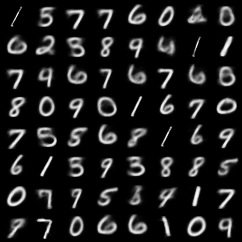

In [32]:
from IPython.display import Image
Image('/VAE.png')

### GAN

Using a different transform pipeline for GAN

In [33]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

Setting model parameters like epochs and batch size

In [34]:
# learning parameters
batch_size = 256
epochs = 150
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator

Importing the data set again with new transforming pipeline

In [35]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Generator Class

In [36]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

Discriminator Class

In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [38]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

Defining optimizers and loss for Generator and Discriminator



In [39]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [40]:
# loss function
criterion = nn.BCELoss()

In [41]:
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

Training functions for Generator and Discriminator

In [42]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [43]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [44]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [45]:
noise = create_noise(sample_size, nz)

In [46]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

Training of the model

In [47]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    epoch_loss_g = loss_g / bi
    epoch_loss_d = loss_d / bi
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

235it [00:13, 17.79it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.89it/s]

Epoch 0 of 150
Generator loss: 2.46087670, Discriminator loss: 1.07933462


235it [00:13, 17.92it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.15it/s]

Epoch 1 of 150
Generator loss: 3.76408052, Discriminator loss: 0.93273938


235it [00:13, 17.96it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.91it/s]

Epoch 2 of 150
Generator loss: 1.49520469, Discriminator loss: 1.10877156


235it [00:12, 18.19it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.54it/s]

Epoch 3 of 150
Generator loss: 1.59326649, Discriminator loss: 1.12787902


235it [00:13, 18.02it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.92it/s]

Epoch 4 of 150
Generator loss: 2.04118133, Discriminator loss: 1.04579437


235it [00:12, 18.33it/s]                         
  1%|          | 2/234 [00:00<00:14, 15.98it/s]

Epoch 5 of 150
Generator loss: 1.01286650, Discriminator loss: 1.25088012


235it [00:12, 18.12it/s]                         
  1%|          | 2/234 [00:00<00:14, 15.99it/s]

Epoch 6 of 150
Generator loss: 1.44335270, Discriminator loss: 0.98345292


235it [00:13, 18.01it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.03it/s]

Epoch 7 of 150
Generator loss: 2.73627639, Discriminator loss: 0.78684837


235it [00:12, 18.09it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.65it/s]

Epoch 8 of 150
Generator loss: 2.42713094, Discriminator loss: 0.66774493


235it [00:13, 17.94it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.07it/s]

Epoch 9 of 150
Generator loss: 2.72649336, Discriminator loss: 0.59615546


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.66it/s]

Epoch 10 of 150
Generator loss: 2.55573773, Discriminator loss: 0.57359475


235it [00:12, 18.21it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.71it/s]

Epoch 11 of 150
Generator loss: 2.65546679, Discriminator loss: 0.60238469


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.62it/s]

Epoch 12 of 150
Generator loss: 2.66566157, Discriminator loss: 0.56726998


235it [00:13, 18.04it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.74it/s]

Epoch 13 of 150
Generator loss: 2.86572099, Discriminator loss: 0.52089584


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:15, 14.98it/s]

Epoch 14 of 150
Generator loss: 2.62946987, Discriminator loss: 0.62127399


235it [00:13, 17.98it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.16it/s]

Epoch 15 of 150
Generator loss: 3.05573750, Discriminator loss: 0.46210974


235it [00:12, 18.21it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.33it/s]

Epoch 16 of 150
Generator loss: 2.87469959, Discriminator loss: 0.52734375


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.33it/s]

Epoch 17 of 150
Generator loss: 2.55717731, Discriminator loss: 0.62375057


235it [00:12, 18.10it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.88it/s]

Epoch 18 of 150
Generator loss: 2.59763360, Discriminator loss: 0.54895729


235it [00:13, 17.93it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.93it/s]

Epoch 19 of 150
Generator loss: 2.78022408, Discriminator loss: 0.51711297


235it [00:12, 18.20it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.03it/s]

Epoch 20 of 150
Generator loss: 2.70700717, Discriminator loss: 0.54463530


235it [00:12, 18.29it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.43it/s]

Epoch 21 of 150
Generator loss: 2.75181222, Discriminator loss: 0.54241109


235it [00:12, 18.64it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.50it/s]

Epoch 22 of 150
Generator loss: 2.71433830, Discriminator loss: 0.56134534


235it [00:12, 18.28it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.56it/s]

Epoch 23 of 150
Generator loss: 2.88310885, Discriminator loss: 0.50549316


235it [00:12, 18.22it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.82it/s]

Epoch 24 of 150
Generator loss: 2.62866879, Discriminator loss: 0.59095824


235it [00:12, 18.37it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.92it/s]

Epoch 25 of 150
Generator loss: 2.74259114, Discriminator loss: 0.54653049


235it [00:12, 18.54it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.29it/s]

Epoch 26 of 150
Generator loss: 2.80574203, Discriminator loss: 0.56505597


235it [00:12, 18.75it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.10it/s]

Epoch 27 of 150
Generator loss: 2.85489178, Discriminator loss: 0.50734591


235it [00:12, 18.67it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.44it/s]

Epoch 28 of 150
Generator loss: 2.62208343, Discriminator loss: 0.60907686


235it [00:12, 18.72it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.57it/s]

Epoch 29 of 150
Generator loss: 2.55528021, Discriminator loss: 0.60119790


235it [00:12, 18.74it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.78it/s]

Epoch 30 of 150
Generator loss: 2.55460572, Discriminator loss: 0.59416515


235it [00:12, 18.57it/s]                         
  1%|          | 2/234 [00:00<00:11, 19.36it/s]

Epoch 31 of 150
Generator loss: 2.48238349, Discriminator loss: 0.63493270


235it [00:12, 18.62it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.96it/s]

Epoch 32 of 150
Generator loss: 2.75751734, Discriminator loss: 0.53432423


235it [00:12, 18.69it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.72it/s]

Epoch 33 of 150
Generator loss: 2.78770375, Discriminator loss: 0.55229282


235it [00:12, 18.62it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.07it/s]

Epoch 34 of 150
Generator loss: 2.75749207, Discriminator loss: 0.58545768


235it [00:12, 18.50it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.77it/s]

Epoch 35 of 150
Generator loss: 2.42087102, Discriminator loss: 0.66317463


235it [00:12, 18.41it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.31it/s]

Epoch 36 of 150
Generator loss: 2.19556832, Discriminator loss: 0.73200756


235it [00:12, 18.38it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.81it/s]

Epoch 37 of 150
Generator loss: 2.27215099, Discriminator loss: 0.66723955


235it [00:12, 18.32it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.29it/s]

Epoch 38 of 150
Generator loss: 2.36913371, Discriminator loss: 0.64648902


235it [00:13, 17.91it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.94it/s]

Epoch 39 of 150
Generator loss: 2.35109687, Discriminator loss: 0.66311491


235it [00:12, 18.53it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.96it/s]

Epoch 40 of 150
Generator loss: 2.34392238, Discriminator loss: 0.66477090


235it [00:12, 18.51it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.56it/s]

Epoch 41 of 150
Generator loss: 2.29421091, Discriminator loss: 0.68050641


235it [00:12, 18.62it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.34it/s]

Epoch 42 of 150
Generator loss: 2.16155386, Discriminator loss: 0.73685014


235it [00:12, 18.66it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.99it/s]

Epoch 43 of 150
Generator loss: 2.00759792, Discriminator loss: 0.78495169


235it [00:12, 18.27it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.02it/s]

Epoch 44 of 150
Generator loss: 2.07709432, Discriminator loss: 0.74769115


235it [00:12, 18.42it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.72it/s]

Epoch 45 of 150
Generator loss: 2.01657581, Discriminator loss: 0.77665669


235it [00:12, 18.37it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.61it/s]

Epoch 46 of 150
Generator loss: 1.88730848, Discriminator loss: 0.82457215


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.33it/s]

Epoch 47 of 150
Generator loss: 1.79834819, Discriminator loss: 0.85115677


235it [00:12, 18.54it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.50it/s]

Epoch 48 of 150
Generator loss: 1.89179206, Discriminator loss: 0.81005085


235it [00:12, 18.38it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.63it/s]

Epoch 49 of 150
Generator loss: 2.01089716, Discriminator loss: 0.78547168


235it [00:12, 18.28it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.01it/s]

Epoch 50 of 150
Generator loss: 1.90719378, Discriminator loss: 0.81786418


235it [00:12, 18.22it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.38it/s]

Epoch 51 of 150
Generator loss: 1.88556302, Discriminator loss: 0.82873607


235it [00:12, 18.40it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.03it/s]

Epoch 52 of 150
Generator loss: 1.87016594, Discriminator loss: 0.84254056


235it [00:12, 18.71it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.12it/s]

Epoch 53 of 150
Generator loss: 1.79401469, Discriminator loss: 0.87274617


235it [00:12, 18.70it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.28it/s]

Epoch 54 of 150
Generator loss: 1.74506164, Discriminator loss: 0.85778886


235it [00:12, 18.44it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.23it/s]

Epoch 55 of 150
Generator loss: 1.73476720, Discriminator loss: 0.87198758


235it [00:12, 18.10it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.42it/s]

Epoch 56 of 150
Generator loss: 1.74264050, Discriminator loss: 0.85903543


235it [00:12, 18.17it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.10it/s]

Epoch 57 of 150
Generator loss: 1.68332326, Discriminator loss: 0.88771558


235it [00:12, 18.38it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.49it/s]

Epoch 58 of 150
Generator loss: 1.69823170, Discriminator loss: 0.89668852


235it [00:12, 18.46it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.66it/s]

Epoch 59 of 150
Generator loss: 1.69439304, Discriminator loss: 0.89374810


235it [00:12, 18.53it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.80it/s]

Epoch 60 of 150
Generator loss: 1.71268821, Discriminator loss: 0.90469611


235it [00:12, 18.44it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.06it/s]

Epoch 61 of 150
Generator loss: 1.68124890, Discriminator loss: 0.88749677


235it [00:12, 18.47it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.31it/s]

Epoch 62 of 150
Generator loss: 1.80268180, Discriminator loss: 0.84728235


235it [00:13, 17.91it/s]                         
  1%|          | 2/234 [00:00<00:14, 15.76it/s]

Epoch 63 of 150
Generator loss: 1.69528234, Discriminator loss: 0.88324064


235it [00:12, 18.12it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.36it/s]

Epoch 64 of 150
Generator loss: 1.61742306, Discriminator loss: 0.90772665


235it [00:12, 18.54it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.73it/s]

Epoch 65 of 150
Generator loss: 1.65908074, Discriminator loss: 0.90661877


235it [00:12, 18.31it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.02it/s]

Epoch 66 of 150
Generator loss: 1.59437001, Discriminator loss: 0.92813814


235it [00:12, 18.50it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.08it/s]

Epoch 67 of 150
Generator loss: 1.60066557, Discriminator loss: 0.92675304


235it [00:12, 18.38it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.43it/s]

Epoch 68 of 150
Generator loss: 1.61388397, Discriminator loss: 0.93211311


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.21it/s]

Epoch 69 of 150
Generator loss: 1.62736940, Discriminator loss: 0.91907769


235it [00:12, 18.68it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.56it/s]

Epoch 70 of 150
Generator loss: 1.54550731, Discriminator loss: 0.94819909


235it [00:12, 18.60it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.38it/s]

Epoch 71 of 150
Generator loss: 1.59085000, Discriminator loss: 0.93966645


235it [00:13, 17.93it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.25it/s]

Epoch 72 of 150
Generator loss: 1.49678242, Discriminator loss: 0.96505684


235it [00:13, 17.91it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.67it/s]

Epoch 73 of 150
Generator loss: 1.47772992, Discriminator loss: 0.98190492


235it [00:13, 17.63it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.05it/s]

Epoch 74 of 150
Generator loss: 1.45211148, Discriminator loss: 0.99563271


235it [00:13, 17.79it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.37it/s]

Epoch 75 of 150
Generator loss: 1.43386638, Discriminator loss: 0.99807942


235it [00:12, 18.34it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.43it/s]

Epoch 76 of 150
Generator loss: 1.44344449, Discriminator loss: 0.99318266


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.49it/s]

Epoch 77 of 150
Generator loss: 1.42271292, Discriminator loss: 1.00324881


235it [00:12, 18.31it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.13it/s]

Epoch 78 of 150
Generator loss: 1.40949285, Discriminator loss: 1.01324797


235it [00:12, 18.31it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.89it/s]

Epoch 79 of 150
Generator loss: 1.39209461, Discriminator loss: 1.01927698


235it [00:12, 18.29it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.97it/s]

Epoch 80 of 150
Generator loss: 1.36482131, Discriminator loss: 1.03144622


235it [00:12, 18.14it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.37it/s]

Epoch 81 of 150
Generator loss: 1.43094933, Discriminator loss: 1.01487029


235it [00:12, 18.17it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.95it/s]

Epoch 82 of 150
Generator loss: 1.41389430, Discriminator loss: 1.01197600


235it [00:12, 18.35it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.41it/s]

Epoch 83 of 150
Generator loss: 1.39230490, Discriminator loss: 1.01684487


235it [00:12, 18.47it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.76it/s]

Epoch 84 of 150
Generator loss: 1.38726616, Discriminator loss: 1.02308416


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.15it/s]

Epoch 85 of 150
Generator loss: 1.38256216, Discriminator loss: 1.04076028


235it [00:12, 18.36it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.80it/s]

Epoch 86 of 150
Generator loss: 1.33735585, Discriminator loss: 1.03514338


235it [00:12, 18.09it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.34it/s]

Epoch 87 of 150
Generator loss: 1.34587586, Discriminator loss: 1.04337537


235it [00:13, 17.87it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.97it/s]

Epoch 88 of 150
Generator loss: 1.30126369, Discriminator loss: 1.05385339


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.11it/s]

Epoch 89 of 150
Generator loss: 1.28799534, Discriminator loss: 1.06719673


235it [00:12, 18.35it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.76it/s]

Epoch 90 of 150
Generator loss: 1.28350794, Discriminator loss: 1.06870401


235it [00:12, 18.35it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.93it/s]

Epoch 91 of 150
Generator loss: 1.26102126, Discriminator loss: 1.07989597


235it [00:12, 18.14it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.99it/s]

Epoch 92 of 150
Generator loss: 1.28075433, Discriminator loss: 1.06824422


235it [00:12, 18.26it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.86it/s]

Epoch 93 of 150
Generator loss: 1.30591452, Discriminator loss: 1.07255530


235it [00:12, 18.11it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.08it/s]

Epoch 94 of 150
Generator loss: 1.26536345, Discriminator loss: 1.08353209


235it [00:13, 18.01it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.98it/s]

Epoch 95 of 150
Generator loss: 1.24203205, Discriminator loss: 1.08593214


235it [00:12, 18.29it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.28it/s]

Epoch 96 of 150
Generator loss: 1.26099849, Discriminator loss: 1.09056461


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.10it/s]

Epoch 97 of 150
Generator loss: 1.23919237, Discriminator loss: 1.09935939


235it [00:12, 18.46it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.97it/s]

Epoch 98 of 150
Generator loss: 1.27098846, Discriminator loss: 1.07446694


235it [00:12, 18.33it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.97it/s]

Epoch 99 of 150
Generator loss: 1.25808549, Discriminator loss: 1.08223927


235it [00:12, 18.15it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.14it/s]

Epoch 100 of 150
Generator loss: 1.25368249, Discriminator loss: 1.09162271


235it [00:12, 18.28it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.88it/s]

Epoch 101 of 150
Generator loss: 1.22044563, Discriminator loss: 1.10824382


235it [00:12, 18.31it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.26it/s]

Epoch 102 of 150
Generator loss: 1.19547188, Discriminator loss: 1.11988354


235it [00:12, 18.25it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.22it/s]

Epoch 103 of 150
Generator loss: 1.19734931, Discriminator loss: 1.11161363


235it [00:12, 18.22it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.21it/s]

Epoch 104 of 150
Generator loss: 1.18629873, Discriminator loss: 1.11438441


235it [00:12, 18.48it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.82it/s]

Epoch 105 of 150
Generator loss: 1.20118785, Discriminator loss: 1.11249876


235it [00:12, 18.39it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.08it/s]

Epoch 106 of 150
Generator loss: 1.20408106, Discriminator loss: 1.11787200


235it [00:12, 18.09it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.78it/s]

Epoch 107 of 150
Generator loss: 1.18987393, Discriminator loss: 1.12970781


235it [00:12, 18.54it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.70it/s]

Epoch 108 of 150
Generator loss: 1.19806647, Discriminator loss: 1.12281787


235it [00:12, 18.51it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.84it/s]

Epoch 109 of 150
Generator loss: 1.18734896, Discriminator loss: 1.11669636


235it [00:12, 18.58it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.18it/s]

Epoch 110 of 150
Generator loss: 1.20764816, Discriminator loss: 1.10925329


235it [00:12, 18.37it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.17it/s]

Epoch 111 of 150
Generator loss: 1.18584502, Discriminator loss: 1.11888111


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.82it/s]

Epoch 112 of 150
Generator loss: 1.19978261, Discriminator loss: 1.12203348


235it [00:12, 18.49it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.51it/s]

Epoch 113 of 150
Generator loss: 1.19440579, Discriminator loss: 1.12374866


235it [00:12, 18.69it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.75it/s]

Epoch 114 of 150
Generator loss: 1.19262159, Discriminator loss: 1.11859393


235it [00:12, 18.57it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.78it/s]

Epoch 115 of 150
Generator loss: 1.19176602, Discriminator loss: 1.11811721


235it [00:12, 18.56it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.12it/s]

Epoch 116 of 150
Generator loss: 1.17457581, Discriminator loss: 1.12112927


235it [00:12, 18.47it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.20it/s]

Epoch 117 of 150
Generator loss: 1.15745258, Discriminator loss: 1.13706040


235it [00:12, 18.61it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.09it/s]

Epoch 118 of 150
Generator loss: 1.17040086, Discriminator loss: 1.13509536


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.04it/s]

Epoch 119 of 150
Generator loss: 1.18514001, Discriminator loss: 1.12569559


235it [00:12, 18.60it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.99it/s]

Epoch 120 of 150
Generator loss: 1.14195836, Discriminator loss: 1.14719117


235it [00:12, 18.66it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.75it/s]

Epoch 121 of 150
Generator loss: 1.11666799, Discriminator loss: 1.15590155


235it [00:12, 18.59it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.62it/s]

Epoch 122 of 150
Generator loss: 1.10199070, Discriminator loss: 1.16652536


235it [00:12, 18.12it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.55it/s]

Epoch 123 of 150
Generator loss: 1.12765670, Discriminator loss: 1.15704501


235it [00:12, 18.55it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.68it/s]

Epoch 124 of 150
Generator loss: 1.10165608, Discriminator loss: 1.15928483


235it [00:12, 18.43it/s]                         
  1%|          | 2/234 [00:00<00:11, 19.41it/s]

Epoch 125 of 150
Generator loss: 1.13314009, Discriminator loss: 1.15361476


235it [00:12, 18.34it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.04it/s]

Epoch 126 of 150
Generator loss: 1.12635112, Discriminator loss: 1.15112901


235it [00:12, 18.52it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.62it/s]

Epoch 127 of 150
Generator loss: 1.15504789, Discriminator loss: 1.14060867


235it [00:12, 18.68it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.46it/s]

Epoch 128 of 150
Generator loss: 1.12580812, Discriminator loss: 1.14935493


235it [00:12, 18.62it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.72it/s]

Epoch 129 of 150
Generator loss: 1.14192462, Discriminator loss: 1.14338338


235it [00:12, 18.43it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.13it/s]

Epoch 130 of 150
Generator loss: 1.11795068, Discriminator loss: 1.15362680


235it [00:12, 18.47it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.82it/s]

Epoch 131 of 150
Generator loss: 1.11983204, Discriminator loss: 1.15510774


235it [00:12, 18.20it/s]                         
  1%|          | 2/234 [00:00<00:11, 19.39it/s]

Epoch 132 of 150
Generator loss: 1.10248017, Discriminator loss: 1.16842234


235it [00:12, 18.23it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.79it/s]

Epoch 133 of 150
Generator loss: 1.10526550, Discriminator loss: 1.16241205


235it [00:12, 18.30it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.16it/s]

Epoch 134 of 150
Generator loss: 1.09825444, Discriminator loss: 1.16713774


235it [00:12, 18.69it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.14it/s]

Epoch 135 of 150
Generator loss: 1.08911717, Discriminator loss: 1.17643106


235it [00:13, 18.01it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.03it/s]

Epoch 136 of 150
Generator loss: 1.07771754, Discriminator loss: 1.19059324


235it [00:12, 18.44it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.43it/s]

Epoch 137 of 150
Generator loss: 1.12594259, Discriminator loss: 1.15943682


235it [00:12, 18.49it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.80it/s]

Epoch 138 of 150
Generator loss: 1.09678686, Discriminator loss: 1.16321862


235it [00:12, 18.36it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.64it/s]

Epoch 139 of 150
Generator loss: 1.10547805, Discriminator loss: 1.16739643


235it [00:12, 18.62it/s]                         
  1%|          | 2/234 [00:00<00:12, 17.99it/s]

Epoch 140 of 150
Generator loss: 1.08897960, Discriminator loss: 1.16764677


235it [00:12, 18.65it/s]                         
  1%|          | 2/234 [00:00<00:14, 16.51it/s]

Epoch 141 of 150
Generator loss: 1.07691586, Discriminator loss: 1.18222678


235it [00:12, 18.60it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.42it/s]

Epoch 142 of 150
Generator loss: 1.07160592, Discriminator loss: 1.17500699


235it [00:12, 18.52it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.10it/s]

Epoch 143 of 150
Generator loss: 1.04636955, Discriminator loss: 1.19879687


235it [00:12, 18.73it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.05it/s]

Epoch 144 of 150
Generator loss: 1.04835474, Discriminator loss: 1.19585192


235it [00:12, 18.54it/s]                         
  1%|          | 2/234 [00:00<00:13, 17.44it/s]

Epoch 145 of 150
Generator loss: 1.02737260, Discriminator loss: 1.19667101


235it [00:12, 18.67it/s]                         
  1%|          | 2/234 [00:00<00:12, 18.77it/s]

Epoch 146 of 150
Generator loss: 1.06114471, Discriminator loss: 1.18882489


235it [00:12, 18.53it/s]                         
  1%|          | 2/234 [00:00<00:12, 19.25it/s]

Epoch 147 of 150
Generator loss: 1.05872858, Discriminator loss: 1.18727314


235it [00:12, 18.70it/s]                         
  1%|          | 2/234 [00:00<00:13, 16.59it/s]

Epoch 148 of 150
Generator loss: 1.06236398, Discriminator loss: 1.18895471


235it [00:12, 18.66it/s]                         

Epoch 149 of 150
Generator loss: 1.06746352, Discriminator loss: 1.18520200


Generate MNIST from Generator and display it

In [48]:
with torch.no_grad():
    generated_img = generator(noise).cpu().detach()
    save_image(generated_img.view(64, 1, 28, 28), '/GAN' + '.png')

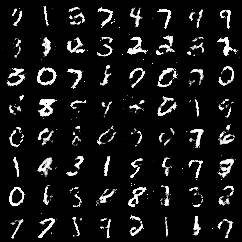

In [49]:
from IPython.display import Image
Image('/GAN.png')

Plot Generator Loss vs Discriminator Loss

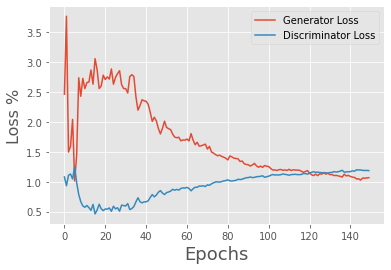

In [50]:
fig = plt.figure()
plt.plot(losses_g,label='Generator Loss')
plt.plot(losses_d,label='Discriminator Loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss %', fontsize=16)
plt.legend()
fig.savefig('vsgraph.png')

### MNIST predictor model for testing GAN and VAE predictions

Defining parameters for model

In [51]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Loading data set with different transformations than GAN and VAE

In [52]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/images/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/images/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /images/MNIST/raw/train-images-idx3-ubyte.gz to /images/MNIST/raw


Extracting /images/MNIST/raw/train-labels-idx1-ubyte.gz to /images/MNIST/raw




Extracting /images/MNIST/raw/t10k-images-idx3-ubyte.gz to /images/MNIST/raw


Extracting /images/MNIST/raw/t10k-labels-idx1-ubyte.gz to /images/MNIST/raw
Processing...
Done!


In [53]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Model class

In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Defining optimizer

In [55]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [56]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

Training function

In [57]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

Test function

In [58]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Training and testing the model

In [59]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))




Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.260970
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295450
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.239506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274136
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.225711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.168033
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.138118
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.945130
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.949193
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750880
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642634
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.585531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.416778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.314595
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.256788
Train Epoch: 1 [12160/

Checking GAN prediction

In [60]:
with torch.no_grad():
    output_gan = network(generated_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


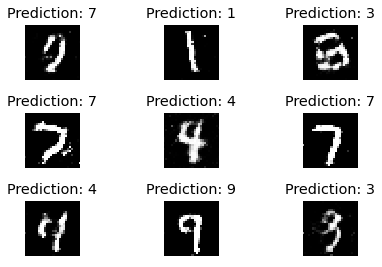

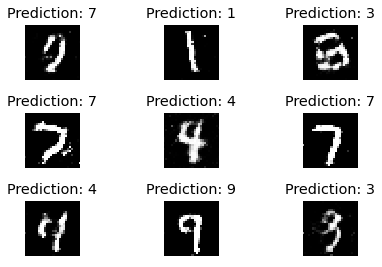

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(generated_img[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output_gan.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Checking VAE prediction

In [63]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z).view(64,1,28,28)
    output_vae = network(sample)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


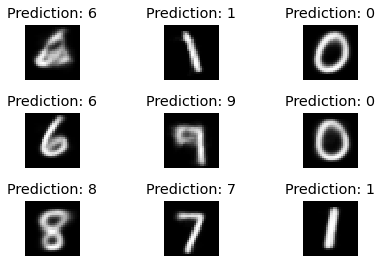

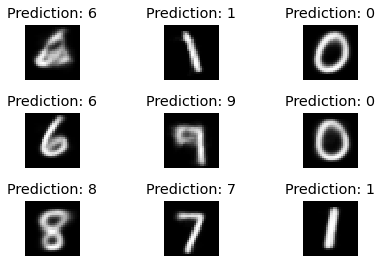

In [64]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(sample[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output_vae.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig